# LIME for tabular data

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

Let's train an xgboost model on tabular data and explain it with LIME.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Split data

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

## XGBoost

In [4]:
# fit model

gbm = XGBRegressor(
    importance_type="gain",
    n_estimators=50,
    max_depth=3,
    random_state=3,
)

gbm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=3, ...)

In [5]:
# R2 in train set

gbm.score(X_train, y_train)

0.8195393445915184

In [6]:
# R2 in test set

gbm.score(X_test, y_test)

0.792226727552409

The model explains ~80% of the variability in the target variable.

## Global explanations - feature importance

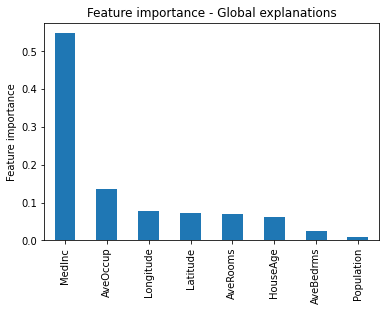

In [7]:
# gbm importance

global_exp = pd.Series(gbm.feature_importances_, index=gbm.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Local explanations

In [8]:
import eli5

In [9]:
# pick one observation

sample_id = 14740

X_test.loc[sample_id]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Latitude        32.580000
Longitude     -117.050000
Name: 14740, dtype: float64

In [10]:
# feature contribution for 1 sample

eli5.show_prediction(
    gbm, 
    X_test.loc[sample_id], 
    feature_names=gbm.feature_names_in_,
)

## Local explanation with LIME

### Create synthetic data

In [11]:
# Let's first scale the data

scaler = StandardScaler().set_output(transform="pandas").fit(X_train)

X_test_sc = scaler.transform(X_test)

In [12]:
# create dataframe for the synthetic data

# containing the observation we want to explain

# we use the scaled data point

synthetic = pd.concat(
    [X_test_sc.loc[sample_id].to_frame().T]* 500, 
    ignore_index=True,
)

synthetic.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.150777,-0.52545,0.104772,-0.042637,0.109472,0.166,-1.425246,1.254236
1,0.150777,-0.52545,0.104772,-0.042637,0.109472,0.166,-1.425246,1.254236
2,0.150777,-0.52545,0.104772,-0.042637,0.109472,0.166,-1.425246,1.254236
3,0.150777,-0.52545,0.104772,-0.042637,0.109472,0.166,-1.425246,1.254236
4,0.150777,-0.52545,0.104772,-0.042637,0.109472,0.166,-1.425246,1.254236


In [13]:
# get random noise

prng = np.random.RandomState(1234567890)

noise = prng.normal(loc=0.0, scale=1.0, size=[500, len(X_test.columns)])

noise

array([[ 1.34016346,  1.73759123,  1.49898834, ...,  2.17032495,
         1.59645265, -0.76945156],
       [ 0.56605824, -0.11927018, -0.1465108 , ..., -0.82819136,
         1.32667483,  1.05986776],
       [ 2.14408873, -1.43464512,  2.28743654, ..., -0.81239806,
         0.29888126, -0.83479401],
       ...,
       [ 0.70233205, -0.72573225, -0.59132546, ..., -0.59640511,
         1.63133676,  0.25650231],
       [-0.1323479 , -0.44800779,  1.30490748, ..., -0.51076561,
        -0.56863958,  1.17792042],
       [ 0.41394751,  0.81170222,  1.50012185, ..., -0.30534475,
         2.73280777, -0.28121639]])

In [14]:
# add random noise centred at 0

synthetic = synthetic + noise

synthetic.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.490940,1.212141,1.603760,-0.271280,2.140506,2.336325,0.171206,0.484785
1,0.716835,-0.644720,-0.041739,-0.841540,0.881305,-0.662192,-0.098572,2.314104
2,2.294865,-1.960095,2.392208,0.386012,-1.167886,-0.646398,-1.126365,0.419442
3,0.723123,-0.181086,2.170604,0.298293,-0.953013,1.210703,-0.664747,1.974511
4,0.965094,-0.793622,0.966260,-0.446249,0.679576,1.517853,-0.619360,1.136390


### Obtain black-box predictions

In [15]:
# unscale data points

synthetic_raw = scaler.inverse_transform(synthetic)

In [16]:
# obtain predictions of black box

bb_preds = gbm.predict(synthetic_raw)

bb_preds[0:10]

array([2.3009527 , 0.6393877 , 4.7190075 , 1.3002394 , 1.9406127 ,
       1.2802658 , 3.0196488 , 1.7516143 , 0.34552273, 3.8382933 ],
      dtype=float32)

### Obtain weights

In [17]:
# obtain the similarity between the data points and the
# observations we want to explain

w = pairwise_distances(
    X=synthetic,
    Y=X_test_sc.loc[[sample_id]],
    metric="euclidean",)

w[0:10]

array([[4.36928271],
       [2.27142507],
       [3.89220671],
       [2.8543822 ],
       [2.11091466],
       [2.92705161],
       [2.90590745],
       [2.01034669],
       [2.94401782],
       [3.58605797]])

In [18]:
# we pass the distance to the exponential kernel

kernel_width = 5

w = np.exp(-w**2/kernel_width)

w[0:10]

array([[0.02196893],
       [0.35633842],
       [0.04832266],
       [0.19602765],
       [0.41016649],
       [0.18022914],
       [0.18473007],
       [0.44561552],
       [0.17667415],
       [0.0763855 ]])

### Train surrogate

In [19]:
# train a decision tree

tree = DecisionTreeRegressor(max_depth=3, random_state=10)

tree.fit(synthetic_raw, bb_preds, w[:, 0])

DecisionTreeRegressor(max_depth=3, random_state=10)

The prediction of the surrogate and the xgb are quite far apart. We can't really trust them.

In [20]:
# the fidelity of the surrogate

tree.score(synthetic_raw, bb_preds)

0.7652404445915766

The fidelity is not great, but it's not super bad either.

In [21]:
# the prediction of the surrogate

tree.predict(X_test.loc[[sample_id]])

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


array([1.45070895])

In [22]:
# the prediction of the xgb

gbm.predict(X_test.loc[[sample_id]])

array([1.4852462], dtype=float32)

### Explain

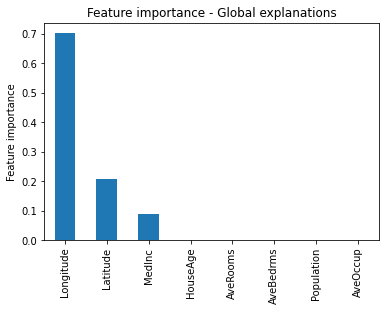

In [23]:
# plot feature importance

global_exp = pd.Series(tree.feature_importances_, index=list(X_test.columns))

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

In [24]:
# feature contribution for 1 sample

eli5.show_prediction(
    tree, 
    X_test.loc[sample_id], 
    feature_names=list(X_test.columns),
)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


This explanation also differs from that of ELI5 that we extract directly from the xgboost model.

It makes sense. With LIME we are taking a massive detour to arrive at the same place. Surely some of the uncertainty introduced has to have some consequences on the analysis.

You probably got a feeling of how many things we can tweak to obtain explanations. It is quite complicated and it can lead to different explanations.

So my 2 cent: DO NOT use LIME for tabular data.